In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import torch
from torch_geometric.data import Data
import torch.nn.functional as F
import warnings
import os
warnings.filterwarnings('ignore')
from torch_geometric.loader import NeighborLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
%matplotlib inline

In [2]:
os.chdir("Trustwatch")
%pwd

'/home/jovyan/Trustwatch'

In [3]:
num_of_ctg = 10
learning_rounds = 3
epochs = 10
hosts = ['051.txt','501.txt','201.txt']
TRAIN=False

In [4]:
from pprint import pprint
import json
import copy

import gensim
from gensim.models import Word2Vec
from multiprocessing import Pool
from itertools import compress
from tqdm import tqdm
import time

import multiprocessing
import random

In [5]:
import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from collections import Counter
from gensim.models import Word2Vec
from multiprocessing import Pool
from itertools import compress
from tqdm import tqdm
import time

def infer(doc,word2vec):  
    word_emb = []
    for word in doc:
        if word in word2vec.wv:
            word_emb.append(word2vec.wv[word])
            
    if len(word_emb) == 0:
        return np.zeros(20)

    out_emb = torch.tensor(word_emb,dtype=torch.float)
    out_emb = out_emb.detach().cpu().numpy()
    out_emb = np.mean(out_emb,axis=0)
    return out_emb

In [6]:
def preprocess(data):
    new_data = {}
    for x in data:
        check1 = x['object'] in ['PROCESS','FILE','FLOW','MODULE']
        check2 = not (x['action'] in ['START','TERMINATE'])
        check3 = x['actorID'] != x['objectID']
        key = (x['action'],x['actorID'],x['objectID'],x['object'],x['pid'],x['ppid'])
        if check1 and check2 and check3:
            new_data[key] = x
    return list(new_data.values())

In [7]:
def Extract_Semantic_Info(event):
    object_type = event['object']
    properties = event['properties']

    label_mapping = {
        "PROCESS": ('parent_image_path', 'image_path'),
        "FILE": ('image_path', 'file_path'),
        "MODULE": ('image_path', 'module_path'),
        "FLOW": ('image_path', 'dest_ip', 'dest_port')
    }

    label_keys = label_mapping.get(object_type, None)
    if label_keys:
        labels = [properties.get(key) for key in label_keys]
        if all(labels):
            event["actorname"], event["objectname"] = labels[0], ' '.join(labels[1:])
            return event
    return None

In [8]:
def describe(x):
    action = x["action"]
    props = x['properties']
    typ = x['object']

    phrase = ''
    try:
        if typ == 'PROCESS':
            phrase = f"{props['parent_image_path']} {action} {props['image_path']} {props['command_line']}" 

        elif typ == 'FILE':
            phrase = f"{props['image_path']} {action} {props['file_path']}"    

        elif typ == 'FLOW':
            phrase = f"{props['image_path']} {action}  {props['dest_ip']} {props['dest_port']} {props['direction']}"    

        else:
            phrase = f"{props['image_path']} {action} {props['module_path']}"
    except:
        phrase = ''
  
    return phrase.split(' ') 

In [9]:
def transform(text):
    text = [event for event in (Extract_Semantic_Info(x) for x in text) if event]
    data = preprocess(text)

    temp = [describe(x) for x in data]
    temp = [x for x in temp if len(x) != 0]

    for i in range(len(data)):
        data[i]['phrase'] = temp[i]
        try:
            data[i]['proc_name'] = data[i]['properties']['image_path']
        except:
            data[i]['proc_name'] = ''

    df = pd.DataFrame.from_dict(data)
    df['timestamp'] = df['timestamp'].str[:-6]
    df['timestamp'] = pd.to_datetime(df['timestamp'],infer_datetime_format=True)
    df.sort_values(by='timestamp', ascending=True,inplace=True)

    return df

def load_data(dataset_id):
    f = open(f"content/data/hosts/{dataset_id}")
    content = [json.loads(line) for line in f]
    return prepare_graph(transform(content))

In [10]:
def prepare_graph(df):
    nodes = {}
    labels = {}
    edges = []
    proc = {}
    dummies = {'PROCESS':0,'FLOW':1,'FILE':2,'MODULE':3}

    for i in range(len(df)):
        x = df.iloc[i]

        actorid = x['actorID']
        if not (actorid in nodes):
            nodes[actorid] = []
        nodes[actorid] += x['phrase']
        labels[actorid] = dummies['PROCESS']

        objectid = x["objectID"]
        if not (objectid in nodes):
            nodes[objectid] = []
        nodes[objectid] += x['phrase']
        labels[objectid] = dummies[x['object']]
        
        edges.append(( actorid, objectid, x['action'] ))
        
        proc[actorid] = x['proc_name']

    features = []
    feat_labels = []
    edge_index = [[],[]]
    index  = {}
    mapp = []
    
    all_procs = set()
              
    for k,v in nodes.items():
        features.append(v)
        feat_labels.append(labels[k])
        index[k] = len(features) - 1
        mapp.append(k)
        
        if k in proc:
            all_procs.add(proc[k])

    for x in edges:
        src = index[x[0]]
        dst = index[x[1]]
    
        edge_index[0].append(src)
        edge_index[1].append(dst)    
    
    idx_to_proc = {}
    for i in range(len(mapp)):
        if mapp[i] in proc:
            idx_to_proc[i] = proc[mapp[i]]
            
    all_procs = list(all_procs)
    
    return features,feat_labels,edge_index,mapp,all_procs,idx_to_proc

In [11]:
from torch_geometric.nn import GCNConv
from torch_geometric.nn import SAGEConv, GATConv
import torch.nn.functional as F
import torch.nn as nn

class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = SAGEConv(20, 32, normalize=True)
        self.conv2 = SAGEConv(32, 20, normalize=True)
        self.linear = nn.Linear(in_features=20, out_features=4)

    def forward(self, x: torch.Tensor, edge_index: torch.Tensor) -> torch.Tensor:
    
        x = self.encode(x, edge_index)
        x = self.linear(x)
        return F.softmax(x, dim=1)
    
    def encode(self, x: torch.Tensor, edge_index: torch.Tensor) -> torch.Tensor:
        
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x
    
    def freeze_conv_layers(self):
        for param in self.conv1.parameters():
            param.requires_grad = False
        for param in self.conv2.parameters():
            param.requires_grad = False

In [12]:
from gensim.models.callbacks import CallbackAny2Vec
import gensim
from gensim.models import Word2Vec
from multiprocessing import Pool
from itertools import compress
from tqdm import tqdm
import time

class EpochSaver(CallbackAny2Vec):

    def __init__(self,client_id):
        self.epoch = 0
        self.cid = client_id

    def on_epoch_end(self, model):
        model.save(f"Content_FL_Exp/{self.cid}.model")
        self.epoch += 1
        
class EpochLogger(CallbackAny2Vec):

    def __init__(self):
        self.epoch = 0

    def on_epoch_begin(self, model):
        pass
        #print("Epoch #{} start".format(self.epoch))

    def on_epoch_end(self, model):
        #print("Epoch #{} end".format(self.epoch))
        self.epoch += 1
        
def train_word2vec_func(docs,client_id):
    logger = EpochLogger()
    saver = EpochSaver(client_id)
    word2vec = Word2Vec(sentences=docs, vector_size=20, window=5, min_count=1,workers=5,epochs=100,callbacks=[saver,logger])

In [13]:
def init_gnns():
    global num_of_ctg
    n = num_of_ctg
    gnn_models = []
    for i in range(n):
        m = GCN().to(device)
        gnn_models.append(m)
    return gnn_models

In [14]:
def define_categories(pids):
    global num_of_ctg
    n = num_of_ctg - 1
    ctg = set(pids)
    ctg = list(ctg)
    k, m = divmod(len(ctg), n)
    return [set(ctg[i * k + min(i, m):(i + 1) * k + min(i + 1, m)]) for i in range(n)]

In [15]:
def map_pids_to_category_indices(pids, categories):
    pid_to_category_index = {}
    
    for pid in pids:
        for category_index, category_set in enumerate(categories):
            if pid in category_set:
                pid_to_category_index[pid] = category_index
                break 
    
    return pid_to_category_index

In [16]:
procs_total = []
data_cache = {}
categories = None

def load_clients_data(client_ids):
    
    global data_cache,categories,procs_total
    
    for x in client_ids:
        docs,labels,edges,mapp,pids,idx_to_pid = load_data(x)
        data_cache[x] = [docs,labels,edges,mapp,pids,idx_to_pid]
        procs_total = procs_total + pids
        
    categories = define_categories(procs_total)

In [17]:
from torch.nn import CrossEntropyLoss
from sklearn.utils import class_weight
import copy

templates = init_gnns()

def train_gnn_func(nodes,labels,edges,mapp,pids,idx_to_pid):
    
    global categories ,epochs
    
    pid_to_gnn_index = map_pids_to_category_indices(pids, categories)
    
    set_pids = set(pids)

    proc_index = list(idx_to_pid.keys())

    train_splits = [[] for _ in range(len(categories))]
    
    for i in proc_index:
        pname = idx_to_pid[str(i)]
        split_indx = pid_to_gnn_index[pname]
        train_splits[split_indx].append(int(i))
        
    local_models = [copy.deepcopy(x) for x in templates]
    
    for i in range(len(local_models)-1):
            
        if len(train_splits[i]) == 0:
            local_models[i] = None
        else:
            if f"global{i}.pth" in os.listdir("Content_FL_Exp"):
                local_models[i].load_state_dict(torch.load(f"Content_FL_Exp/global{i}.pth"))

            optimizer = torch.optim.Adam(local_models[i].parameters(), lr=0.01, weight_decay=5e-4)
            criterion = CrossEntropyLoss()

            graph = Data(x=torch.tensor(nodes,dtype=torch.float).to(device),y=torch.tensor(labels,dtype=torch.long).to(device), edge_index=torch.tensor(edges,dtype=torch.long).to(device))
            mask = torch.tensor([False]*graph.num_nodes, dtype=torch.bool)
            mask[train_splits[i]] = True
            
            def get_neighbors(edge_index, nodes):
                neighbors = []
                for node in nodes:
                    mask = edge_index[0] == node
                    neighbors.extend(edge_index[1, mask].tolist())
                return torch.tensor(list(set(neighbors)), dtype=torch.long)

            one_hop_neighbors = get_neighbors(graph.edge_index, train_splits[i])
            two_hop_neighbors = get_neighbors(graph.edge_index, one_hop_neighbors)
            two_hop_neighbors = two_hop_neighbors[~mask[two_hop_neighbors]]
            mask[two_hop_neighbors] = True
            
            for epoch in range(epochs):
                print(f'Training GNN Category {i} Model for Epoch {epoch}')

                loader = NeighborLoader(graph, num_neighbors=[-1,-1], batch_size=5000,input_nodes=mask)
                total_loss = 0
                for subg in loader:
                    local_models[i].train()
                    optimizer.zero_grad() 
                    out = local_models[i](subg.x, subg.edge_index) 
                    loss = criterion(out, subg.y) 
                    loss.backward() 
                    optimizer.step()      
                    total_loss += loss.item() * subg.batch_size
                print("Loss: ", total_loss / mask.sum().item(), '\n')
    
    graph = Data(x=torch.tensor(nodes,dtype=torch.float).to(device),y=torch.tensor(labels,dtype=torch.long).to(device), edge_index=torch.tensor(edges,dtype=torch.long).to(device))
    optimizer = torch.optim.Adam(local_models[-1].parameters(), lr=0.01, weight_decay=5e-4)
    criterion = CrossEntropyLoss()
    
    for epoch in range(epochs):
        print(f'Training Catch all GNN Category Model for Epoch {epoch}')    
        local_models[-1].train()
        optimizer.zero_grad() 
        out = local_models[-1](graph.x, graph.edge_index) 
        loss = criterion(out, graph.y) 
        loss.backward() 
        optimizer.step()      
        print(f"Epoch: {epoch}, Loss: {loss.item()}")

    return local_models

In [18]:
def client_handling_loop(client_id):
    print(f"Running Setup on Client {client_id} \n")
    
    docs,labels,edges,mapp,pids,idx_to_pid = data_cache[client_id]
    
    nodes_feat = []
    word2vec = Word2Vec.load(f"Content_FL_Exp/unified_word2vec.model")
    for x in docs:
        nodes_feat.append( infer(x,word2vec) ) 
        
    trained_local_models = train_gnn_func(nodes_feat,labels,edges,mapp,pids,idx_to_pid)
    return trained_local_models

In [19]:
import random
def perform_federated_learning(n_clients):
    client_models = []
    for c in n_clients:
        local_gnns = client_handling_loop(c)
        client_models.append(local_gnns)
    return client_models

In [20]:
def server_aggregate(all_models):
    global_models = copy.deepcopy(templates)
    
    for l in range(len(all_models)):
        
        current_models = all_models[l]
        current_models = [x for x in current_models if x != None]
        
        if not len(current_models) == 0:
        
            global_dict = global_models[l].state_dict()

            for k in global_dict.keys():
                param_list = [current_models[i].state_dict()[k] for i in range(len(current_models))]
                global_dict[k] = torch.stack(param_list, 0).mean(0)

            global_models[l].load_state_dict(global_dict)
            torch.save(global_models[l].state_dict(), f"Content_FL_Exp/global{l}.pth")
                   
    return global_models

In [21]:
from itertools import compress

In [22]:
def helper(MP,acts,objs,GP,edges,mapp):

    all_pids = acts.union(objs)
    GN = all_pids - GP
    MN = all_pids - MP

    TP = MP.intersection(GP)
    FP = MP.intersection(GN)
    FN = MN.intersection(GP)
    
    two_hop_gp = construct_neighborhood(GP,mapp,edges,2)
    two_hop_tp = construct_neighborhood(TP,mapp,edges,2)
    FP = FP - two_hop_gp
    TP = TP.union(FN.intersection(two_hop_tp))
    FN = FN - two_hop_tp

    TP,FPC,FN = len(TP),len(FP),len(FN)
    
    TN = (len(acts) + len(objs)) - TP - FPC - FN
    
    FPR = FPC / (FPC+TN)
    TPR = TP / (TP+FN)
    
    return TP,FPC,FN,TN,FP 

In [23]:
from itertools import compress
from torch_geometric import utils

def construct_neighborhood(ids,mapp,edges,hops):
    if hops == 0:
        return set()
    else:
        neighbors = set()
        for i in range(len(edges[0])):
            if mapp[edges[0][i]] in ids:
                neighbors.add(mapp[edges[1][i]])
            if mapp[edges[1][i]] in ids:
                neighbors.add(mapp[edges[0][i]])
        return neighbors.union( construct_neighborhood(neighbors,mapp,edges,hops-1) )

In [24]:
if TRAIN:
    !rm Content_FL_Exp/global*.pth

In [25]:
#load_clients_data(hosts)

In [26]:
with open('Content_FL_Exp/optc_ensemble_ben.json', 'r') as f:
    data_cache = json.load(f)

proc_total = []
for x in ['051.txt','501.txt','201.txt']:
    proc_total = proc_total + data_cache[x][-2]
    
categories = define_categories(proc_total)

In [27]:
import random

if TRAIN:
    for r in range(learning_rounds):
        print(f"Federated Learning Round Number: {r}\n")
        client_models = perform_federated_learning(hosts)
        arranged_models =  [list(group) for group in zip(*client_models)]
        global_models = server_aggregate(arranged_models)

In [28]:
data_cache_mal = {}

def load_test_data():
    global data_cache_mal
        
    for x in ['201','501','051']:
        path = f"Content_FL_Exp/eval_data/SysClient0{x}.systemia.com.txt"
        f = open(path)
        content = [json.loads(line) for line in f]
        docs,labels,edges,mapp,pids,idx_to_pid = prepare_graph(transform(content))
        data_cache_mal[x] = [docs,labels,edges,mapp,pids,idx_to_pid]

In [29]:
#load_data_test()

In [30]:
with open('Content_FL_Exp/optc_ensemble_mal.json', 'r') as f:
    data_cache_mal = json.load(f)

In [31]:
from collections import Counter

In [32]:
TP,FP,FN,TN = 0,0,0,0
FPL = set()
for data_id in ['201','501','051']:

    docs,labels,edges,mapp,pids,idx_to_pid = data_cache_mal[data_id]

    nodes_feat = []
    word2vec = Word2Vec.load(f"Content_FL_Exp/unified_word2vec.model")
    for x in docs:
        nodes_feat.append( infer(x,word2vec) ) 

    with open(f"gt_{data_id}.json", "r") as json_file:
        gt,acts,objs = json.load(json_file)  

    gt,acts,objs = set(gt),set(acts),set(objs)

    graph = Data(x=torch.tensor(nodes_feat,dtype=torch.float).to(device),y=torch.tensor(labels,dtype=torch.long).to(device), edge_index=torch.tensor(edges,dtype=torch.long).to(device))

    flag = torch.tensor([True]*graph.num_nodes, dtype=torch.bool)

    model = GCN().to(device)

    for m_n in range(num_of_ctg):
        if f"global{m_n}.pth" in os.listdir("Content_FL_Exp"): 
            model.load_state_dict(torch.load(f"Content_FL_Exp/global{m_n}.pth",map_location=torch.device('cpu')))
            
        model.eval()
        out = model(graph.x, graph.edge_index)

        sorted, indices = out.sort(dim=1,descending=True)
        conf = (sorted[:,0] - sorted[:,1]) / sorted[:,0]
        conf = (conf - conf.min()) / conf.max()

        pred = indices[:,0]
        cond = (pred == graph.y) & (conf >= 0.7)
        flag[cond] = torch.logical_and(flag[cond], torch.tensor([False]*len(flag[cond]), dtype=torch.bool))

    index = utils.mask_to_index(flag).tolist()
    ids = set([mapp[x] for x in index])

    metrics = helper(set(ids),acts,objs,gt,edges,mapp) 
        
    fp = [i for i in range(len(mapp)) if mapp[i] in metrics[4] and labels[i] in [0,1,2]]
          
    TP = TP + metrics[0]
    FP = FP + len(fp)
    FN = FN + metrics[2]
    TN = TN + metrics[3]

print(f"Number of True Positives: {TP}")
print(f"Number of Fasle Positives: {FP}")
print(f"Number of False Negatives: {FN}")

prec = TP / (TP + FP)
print(f"Precision: {prec}")

rec = TP / (TP + FN)
print(f"Recall: {rec}")

fscore = (2*prec*rec) / (prec + rec)
print(f"Fscore: {fscore}\n")

Number of True Positives: 615
Number of Fasle Positives: 65
Number of False Negatives: 35
Precision: 0.9044117647058824
Recall: 0.9461538461538461
Fscore: 0.9248120300751879



In [40]:
from pyvis.network import Network
import networkx as nx
from torch_geometric.utils import k_hop_subgraph

# Define the visualization function
def visualize_explanation(node_idx, graph, explanation):
    # Extract the subgraph around the node of interest
    subset, edge_index, mapping, hard_edge_mask = k_hop_subgraph(
        node_idx, num_hops=2, edge_index=graph.edge_index, relabel_nodes=True
    )
    edge_mask = explanation.edge_mask[hard_edge_mask].cpu().detach().numpy()
    edge_mask = (edge_mask - edge_mask.min()) / (edge_mask.max() - edge_mask.min() + 1e-6)
    
    # Create a NetworkX graph
    G = nx.Graph()
    edge_list = edge_index.cpu().numpy().T
    G.add_edges_from(edge_list)
    
    # Get node labels from graph.node_labels
    subset_indices = subset.cpu().numpy()
    node_labels = [graph.node_labels[i] for i in subset_indices]
    
    # Initialize PyVis network
    net = Network(notebook=True, cdn_resources='in_line', width='100%', height='750px')
    
    # Add nodes with labels and colors
    for i, node in enumerate(G.nodes()):
        node = int(node)  # Ensure node ID is an int
        label = node_labels[i]
        # Shorten label for display if necessary
        short_label = label if len(label) <= 15 else label[:15] + '...'
        title = f"Node {subset_indices[i]}: {label}"
        color = 'red' if int(subset_indices[i]) == int(node_idx) else 'blue'
        net.add_node(node, label=short_label, title=title, color=color)
    
    # Add edges with edge weights (from edge_mask)
    for i, (u, v) in enumerate(G.edges()):
        u = int(u)  # Ensure node IDs are ints
        v = int(v)
        weight = float(edge_mask[i])  # Convert weight to native Python float
        net.add_edge(u, v, value=weight, title=f"Edge weight: {weight:.2f}")
    
    # Customize physics and layout
    net.set_options("""
    var options = {
      "physics": {
        "forceAtlas2Based": {
          "gravitationalConstant": -50,
          "centralGravity": 0.01,
          "springLength": 100,
          "springConstant": 0.08
        },
        "maxVelocity": 50,
        "solver": "forceAtlas2Based",
        "timestep": 0.35,
        "stabilization": {"iterations": 150}
      }
    }
    """)
    
    # Display the interactive network
    net.show('../graph_explanation.html')

In [41]:
from torch_geometric.explain import Explainer, GNNExplainer
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import k_hop_subgraph

TP, FP, FN, TN = 0, 0, 0, 0
FPL = set()
data_id = '051'

docs, labels, edges, mapp, pids, idx_to_pid = data_cache_mal[data_id]

for i in range(len(docs)):
    docs[i] = [s for s in docs[i] if s]
    
node_labels = [x[2] if x else "Undefined" for x in docs]

nodes_feat = []
word2vec = Word2Vec.load(f"Content_FL_Exp/unified_word2vec.model")
for x in docs:
    nodes_feat.append(infer(x, word2vec))

with open(f"gt_{data_id}.json", "r") as json_file:
    gt, acts, objs = json.load(json_file)

gt, acts, objs = set(gt), set(acts), set(objs)

graph = Data(
    x=torch.tensor(nodes_feat, dtype=torch.float).to(device),
    y=torch.tensor(labels, dtype=torch.long).to(device),
    edge_index=torch.tensor(edges, dtype=torch.long).to(device)
)

graph.node_labels = node_labels

flag = torch.tensor([True] * graph.num_nodes, dtype=torch.bool)

model = GCN().to(device)

for m_n in range(num_of_ctg):
    if f"global{m_n}.pth" in os.listdir("Content_FL_Exp"):
        model.load_state_dict(torch.load(f"Content_FL_Exp/global{m_n}.pth", map_location=torch.device('cpu')))

    model.eval()
    out = model(graph.x, graph.edge_index)

    sorted, indices = out.sort(dim=1, descending=True)
    conf = (sorted[:, 0] - sorted[:, 1]) / sorted[:, 0]
    conf = (conf - conf.min()) / conf.max()

    pred = indices[:, 0]
    cond = (pred == graph.y) & (conf >= 0.7)
    flag[cond] = torch.logical_and(flag[cond], torch.tensor([False] * len(flag[cond]), dtype=torch.bool))

index = utils.mask_to_index(flag).tolist()
ids = set([mapp[x] for x in index])

metrics = helper(set(ids), acts, objs, gt, edges, mapp)

fp = [i for i in range(len(mapp)) if mapp[i] in metrics[4] and labels[i] in [0, 1, 2]]

TP = TP + metrics[0]
FP = FP + len(fp)
FN = FN + metrics[2]
TN = TN + metrics[3]

In [95]:
from torch_geometric.explain import Explainer, PGExplainer, ModelConfig
import torch

# Ensure the model is in evaluation mode during explanation setup
model.eval()

# Initialize the Explainer with PGExplainer
explainer = Explainer(
    model=model,
    algorithm=PGExplainer(epochs=30, lr=0.003),
    explanation_type='phenomenon',
    edge_mask_type='object',
    model_config=ModelConfig(
        mode='multiclass_classification',
        task_level='node',
        return_type='log_probs'
    ),
)

# Train the explainer on a set of indices
# Ensure to replace `[...]` with actual indices you want to train against
for epoch in range(30):
    for index in [900]:  # Replace `[...]` with the actual list of indices
        loss = explainer.algorithm.train(
            epoch,
            model,
            graph.x,
            graph.edge_index,
            target=graph.y,
            index=index
        )
        print(f"Epoch {epoch}, Index {index}, Loss {loss}")

# Use the explainer on a specific node index
explanation = explainer(
    x=graph.x,
    edge_index=graph.edge_index,
    target=graph.y,
    index=10
)

# Visualization or further processing of the explanation
# This might involve a function like visualize_explanation if available
visualize_explanation(node_idx, graph, explanation)

Epoch 0, Index 900, Loss 0.32459557056427
Epoch 1, Index 900, Loss 0.3059388995170593
Epoch 2, Index 900, Loss 0.34295621514320374
Epoch 3, Index 900, Loss 0.3244819641113281
Epoch 4, Index 900, Loss 0.340915709733963
Epoch 5, Index 900, Loss 0.30620065331459045
Epoch 6, Index 900, Loss 0.3348388075828552
Epoch 7, Index 900, Loss 0.28341543674468994
Epoch 8, Index 900, Loss 0.3204033374786377
Epoch 9, Index 900, Loss 0.3351432681083679
Epoch 10, Index 900, Loss 0.3182681202888489
Epoch 11, Index 900, Loss 0.30358701944351196
Epoch 12, Index 900, Loss 0.3247605860233307
Epoch 13, Index 900, Loss 0.2685743570327759
Epoch 14, Index 900, Loss 0.27715545892715454
Epoch 15, Index 900, Loss 0.25207388401031494
Epoch 16, Index 900, Loss 0.14641112089157104
Epoch 17, Index 900, Loss 0.26627397537231445
Epoch 18, Index 900, Loss 0.267794668674469
Epoch 19, Index 900, Loss 0.09481802582740784
Epoch 20, Index 900, Loss 0.1924840211868286
Epoch 21, Index 900, Loss 0.15308839082717896
Epoch 22, Inde

In [96]:
# === GNNExplainer Integration ===
# Initialize the Explainer
explainer = Explainer(
    model=model,
    algorithm=GNNExplainer(epochs=200),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='multiclass_classification',
        task_level='node',
        return_type='log_probs',
    ),
)

pred = indices[:, 0]
misclassified = (pred != graph.y) & (graph.y == 0)
nodes_to_explain = misclassified.nonzero(as_tuple=False).squeeze().tolist()

node_idx = nodes_to_explain[900]

explanation = explainer(
    x=graph.x,
    edge_index=graph.edge_index,
    target=graph.y,
    index=node_idx,
)

visualize_explanation(node_idx, graph, explanation)

../graph_explanation.html


In [100]:
from torch_geometric.explain import Explainer, GNNExplainer, AttentionExplainer, GraphMaskExplainer

explainer = Explainer(
    model=model,
    algorithm=GraphMaskExplainer(num_layers=2),
    explanation_type='model',
    edge_mask_type='object',
    model_config=dict(
        mode='multiclass_classification',
        task_level='node',
        return_type='log_probs',
    ),
)

pred = indices[:, 0]
misclassified = (pred != graph.y) & (graph.y == 0)
nodes_to_explain = misclassified.nonzero(as_tuple=False).squeeze().tolist()

node_idx = nodes_to_explain[900]

explanation = explainer(
    x=graph.x,
    edge_index=graph.edge_index,
    target=graph.y,
    index=node_idx,
)

visualize_explanation(node_idx, graph, explanation)

Train explainer for node(s) tensor([40481]) with layer 1: 100%|███████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.21it/s]
Train explainer for node(s) tensor([40481]) with layer 0: 100%|███████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 11.07it/s]
Explain: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 148.19it/s]

../graph_explanation.html


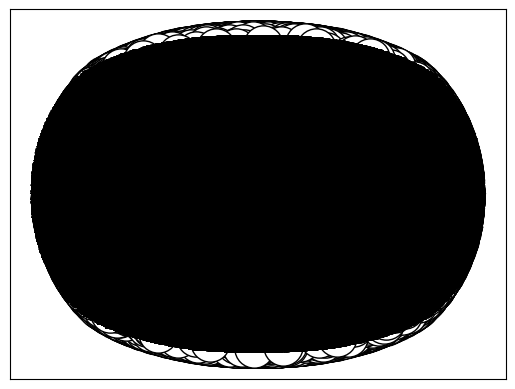

In [101]:
explanation.visualize_graph()

In [91]:
graph.node_labels[6966]

'\\Device\\HarddiskVolume1\\Program'

In [ ]:
#Indices for 051
#1000
#1009
#900